# Machine Learning Programming Exercise 3: One-vs-all

In [1]:
#import package(s)
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sp
import scipy.io as sio 
import math

## 1 Multi-class Classiﬁcation using Logistic Regression
This part of the exercise uses logistic regression to recognize handwritten digits (from $0$ to $9$) by applying the one-vs-all classiﬁcation.

Since $y = \{0, 1,\dots, 9\}$, the problem divided into $10$ binary classification problems where one class is chosen at a time and all others are lumped into a single second class. The logistic regression classiﬁer $h_{\theta} (x)$ is then trained for each class to predict the probability that $y$ is a member of one of these classes: $y=i$, where $i = 0, 1,\dots, 9$. The classiﬁer is trained to learn each class separately so it is train to think that one particular class is a positive class. To make a prediction, we chose the hypothesis that returned the highest value for a particular class. 

### 1.1 Dataset
The file ex3data1.mat contains 5000 training examples from the MNIST handwritten digit dataset. Each training example is a 20 pixel by 20 pixel grayscale image of the digit. Every row of the feature matrix $X$ is a training example for a handwritten digit image.

The 5000-dimensional vector $y$ contains labels for the training set. Due to indexing, the digit zero is mapped to the value ten while the other digits are mapped as normal. That is, a "$0$" digit is labeled as "$10$".

In [2]:
#Setup the parameters you will use for this part of the exercise

#20x20 Input Images of Digits
input_layer_size  = 400  

# 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10       

### 1.2 Visualizing the data
A subset of the training set is visualized by randomly selecting 100 rows from the matrix $X$ and passes those rows to the displayData function. This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together.

Loading and Visualizing Data ...



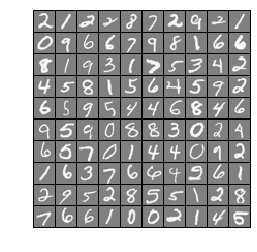

In [3]:
#define function for exercise(s)
def displayData(X):
#DISPLAYDATA Display 2D data in a nice grid
    example_width = int(round(math.sqrt(X.shape[1])))

    # Compute rows, cols
    m,n = X.shape
    example_height = int(n / example_width)

    # Compute number of items to display
    display_rows = int(math.floor(math.sqrt(m)))
    display_cols = int(math.ceil(m / display_rows))

    # Between images padding
    pad = 1

    # Setup blank display
    row_initial = pad + display_rows*(example_height + pad)
    col_initial = pad + display_cols*(example_width + pad)
    display_array = -(np.ones((row_initial, col_initial)))

    # Copy each example into a patch on the display array
    curr_ex = 0
    for j  in range(display_rows):
        for i in range(display_cols):
            if curr_ex > m:
                break 
            # Copy the patch
            
            # Get the max value of the patch
            max_val = max(abs(X[curr_ex, :]))
            
            row_arr = list(map(lambda x:x+pad+j*(example_height + pad), range(example_height+1)))
            col_arr = list(map(lambda x:x+pad+i*(example_width + pad), range(example_width+1)))
            display_array[row_arr[0]:row_arr[-1], col_arr[0]:col_arr[-1]] = np.reshape(X[curr_ex, :], (example_height, example_width)) / max_val
            curr_ex = curr_ex + 1
            
        if curr_ex > m:
            break
    # Display Image
    h = plt.imshow(display_array.T, clim = (-1,1))
    # gray scale the image
    h.set_cmap('gray')
    # Do not show axis
    plt.axis('off')
    plt.show()

# =========== Part 1: Loading and Visualizing Data =============
#  We start the exercise by first loading and visualizing the dataset.
#  You will be working with a dataset that contains handwritten digits.

#Loading and Visualizing Data 
print('Loading and Visualizing Data ...\n')
data = sio.loadmat('ex3data1.mat')
#training data stored in the arrays X, y
X = data['X']
y = data['y']

#m is the number of rows of X
m = X.shape[0]

#Randomly select 100 data points to display
rand_indices = np.random.permutation(m)
sel = X[rand_indices[0:100], :]

displayData(sel)

### 1.3 Vectorizing Logistic Regression

A multi-class classiﬁer is built using multiple one-vs-all logistic regression models. Since there are $10$ classes, $10$ separate logistic regression classiﬁers will need to be trained. To make this training efficient, it is important to ensure that the vectorized version of logistic regression that does not employ any for loops.

**Vectorizing the cost function**

Recall, the cost function for unregularized logistic regression is
$\begin{align*} J(\theta) = \frac{1}{m} \sum_{i=1}^m \left [ -y^{(i)} \log(h_{\theta} (x^{(i)})) - (1-y^{(i)}) \log(1-h_{\theta} (x^{(i)})) \right] \end{align*}$.

Instead of usng a for loop to calculate each example $i$ for the summation, we can use matrix multiplication. Define $y, X,$ and $\theta$ as 
$y = \begin{bmatrix}
       y^{(1)} \\
       y^{(2)} \\
       \vdots \\
       y^{(m)}
       \end{bmatrix} $, $\quad X =\begin{bmatrix}
       -(x^{(1)})^T- \\
       -(x^{(2)})^T- \\
       \vdots \\
       -(x^{(m)})^T-
       \end{bmatrix}$, $\quad \theta = \begin{bmatrix}
       \theta_1 \\
       \theta_2 \\
       \vdots \\
       \theta_n
       \end{bmatrix}$.
 The matrix product for $X\theta$ is 
 $X\theta =\begin{bmatrix}
       -(x^{(1)})^T\theta - \\
       -(x^{(2)})^T\theta - \\
       \vdots \\
       -(x^{(m)})^T\theta -
       \end{bmatrix} = \begin{bmatrix}
       -\theta^T (x^{(1)})- \\
       -\theta^T (x^{(2)})-\\
       \vdots \\
       -\theta^T (x^{(m)})-
       \end{bmatrix}$.
In the last equality, we used the fact that $a^Tb = b^Ta$ if $a$ and $b$ are vectors. This allows us to compute the products $\theta^T x^{(i)}$ for all our examples $i$ in one line of code.
 
So, the vectorized cost function is computed as       
 $\begin{align*} J(\theta) = \frac{1}{m} \left [ -y \log(h_{\theta} (X\theta)) - (1-y) \log(1-h_{\theta} (X\theta)) \right] \end{align*}$. This vectorized cost function is in the function lrCostFunction and it does not contain any loops. 
 
<div class="alert alert-block alert-info">
<b>Debugging Tip:</b>  
Vectorizing code can sometimes be tricky. One common strategy for debugging is to print out the sizes of the matrices using the shape function.
    
Furthermore, if you have a non-vectorized version of your code, then you can compare the output of the vectorized code with non-vectorized code to make sure that they produce the same outputs.
</div>

**Vectorizing the gradient** 

Recall, the gradient for unregularized logistic regression for the $j$th element is 
$\begin{align*} \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left ( ( h_{\theta} (x^{(i)}) -y^{(i)} ) x^{(i)}_j \right) \end{align*}$. To vectorize this operation over the dataset, tart by writing out all the partial derivatives explicitly for all $\theta_j$,

$\begin{bmatrix}
       \frac{\partial J(\theta)}{\partial \theta_0} \\
       \frac{\partial J(\theta)}{\partial \theta_1} \\
       \frac{\partial J(\theta)}{\partial \theta_2} \\
       \vdots \\
       \frac{\partial J(\theta)}{\partial \theta_n}
       \end{bmatrix} = \frac{1}{m} \begin{bmatrix}
       \sum_{i=1}^m \left (( h_{\theta} (x^{(i)}) -y^{(i)} ) x^{(i)}_0 \right)\\
       \sum_{i=1}^m \left (( h_{\theta} (x^{(i)}) -y^{(i)} ) x^{(i)}_1 \right) \\
       \sum_{i=1}^m \left (( h_{\theta} (x^{(i)}) -y^{(i)} ) x^{(i)}_2 \right) \\
       \vdots \\
       \sum_{i=1}^m \left (( h_{\theta} (x^{(i)}) -y^{(i)} ) x^{(i)}_n \right)
       \end{bmatrix}
       = \frac{1}{m} \sum_{i=1}^m \left (( h_{\theta} (x^{(i)}) -y^{(i)} ) x^{(i)} \right) = \frac{1}{m} \begin{bmatrix}
       x^{(1)} & x^{(2)} & \cdots & x^{(m)}
       \end{bmatrix} \begin{bmatrix}
        h_{\theta} (x^{(1)}) -y^{(1)} \\
        h_{\theta} (x^{(2)}) -y^{(2)} \\
       \vdots \\
        h_{\theta} (x^{(m)}) -y^{(m)}
       \end{bmatrix}= \frac{1}{m} X^T ( h_{\theta} (x) -y ) $.
       
The expression above allows us to compute all the partial derivatives without any loops. This vectorized gradient is in the function lrGradient and it does not contain any loops. 

<div class="alert alert-block alert-info">
<b>Tip:</b>  
When implementing the vectorization for regularized logistic regression, use the matrices index to access and update only certain elements of $\theta$.
    
For lrGradient, I computed $\frac{\partial J(\theta)}{\partial \theta_j} = \left ( \frac{1}{m} \sum_{i=1}^m (h_{\theta} (x^{(i)}) -y^{(i)}) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j$ for all values of $j$, then I recalculate the gradient at index zero to be $\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m (h_{\theta} (x^{(i)}) -y^{(i)}) x_0^{(i)}$. Otherwise, you can use the cost function of the unregularized logistic regression for $j=0$ and then use a for loop to calculate the gradient terms for $j \geq 1$.
</div>

I will be optimizing with fmin_tnc, but you can use other optimizing algorithms. The manual used a MATLAB version of fmin_cg, which uses the conjugate gradient algorithm. 

In [4]:
#define function for exercise(s)
def sigmoid(z):
#SIGMOID Compute sigmoid function
#   g = SIGMOID(z) computes the sigmoid of z.
    g = 1/(1 + np.exp(-z))
    return g

def hypfunc(theta,X):
# hypothesis function: returns sigmoid(X * theta)
    X = np.matrix(X)
    theta = np.matrix(theta)
    return sigmoid(X * theta.T)

def lrCostFunction(theta, X, y, learningRate): 
#LRCOSTFUNCTION Compute cost for logistic regression with 
#regularization
#   J = LRCOSTFUNCTION(theta, X, y, lambda) computes the cost of using
#   theta as the parameter for regularized logistic regression
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    h = hypfunc(theta,X)
    first = np.multiply(-y, np.log(h))
    second = np.multiply((1 - y), np.log(1 - h))
    C = (first - second).mean()
    reg = (learningRate*np.sum(np.power(theta[:,1:theta.shape[1]],2)))/(2*len(X))
    return C + reg

def lrGradient(theta, X, y, learningRate):
#LRGRADIENT Compute gradient for logistic regression with 
#regularization
#   J = LRGRADIENT(theta, X, y, lambda) computes the 
#   gradient of the cost w.r.t. to the parameters. 
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    grad = (X.T*(hypfunc(theta,X) - y))/len(X)
    G = grad + ((learningRate / float(len(X))) * theta.T)
    G[0] = (np.multiply(hypfunc(theta,X) - y, X[:,0])).mean()
    return G
    #change G from 2d to 1d
    #return np.ravel(G)

# ============ Part 2a: Vectorize Logistic Regression ============
#  In this part of the exercise, you will reuse your logistic regression
#  code from the last exercise. You task here is to make sure that your
#  regularized logistic regression implementation is vectorized. After
#  that, you will implement one-vs-all classification for the handwritten
#  digit dataset.

#Test case for lrCostFunction
print('\nTesting lrCostFunction() with regularization')
theta_t = np.array([[-2, -1, 1, 2]])
X_t = np.column_stack((np.ones((5,1)), (np.arange(1,16).reshape(3,5).T)/float(10)))
y_t = np.array([[1], [0], [1], [0], [1]])
lambda_t = 3

J = lrCostFunction(theta_t, X_t, y_t, lambda_t)
grad = lrGradient(theta_t, X_t, y_t, lambda_t)

print('\nCost: ', J)
print('Expected cost: 2.534819\n')
print('Gradients: ', grad)
print('Expected gradients:\n')
print(' 0.146561\n -0.548558\n 0.724722\n 1.398003\n')



Testing lrCostFunction() with regularization

Cost:  2.5348193961097443
Expected cost: 2.534819

Gradients:  [[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]
Expected gradients:

 0.146561
 -0.548558
 0.724722
 1.398003



### 1.4 One-vs-all Classiﬁcation
This part of the exercise implements one-vs-all classiﬁcation by training multiple regularized logistic regression classiﬁers, one for each of the $K$ classes in the dataset. In the handwritten digits dataset, $K = 10$, but the code should work for any value of $K$.

The function oneVsAll should return all the classiﬁer parameters in a matrix $\Theta \in \mathbb{R}^{K \times (N+1)}$, where each row of $\Theta$ corresponds to the learned logistic regression parameters for one class. To do this, use a "for"-loop from $1$ to $K$, to train each classiﬁer independently.

When training the classiﬁer for class $k \in \{1,...,K\}$, you will want a $m$-dimensional vector of labels $y$, where $y_j \in 0, 1$ ndicates whether the $j$th training instance belongs to class $k$ $(y_j = 1)$, or if it belongs to a diﬀerent class $(y_j = 0)$. Logical arrays helpful for this task.

<div class="alert alert-block alert-info">
<b>Tip:</b>  
Logical arrays are arrays which contain binary (0 or 1) elements.
    
In the function oneVsAll, I created a logical array using np.array with a conditional statement while interating over $10$ classes. 
</div>

**One-vs-all Prediction**

After training the one-vs-all classifier, you can now use it to predict the digit contained in a given image. For each input, the "probability" that it belongs to each class is computed using the trained logistic regression classifiers. The one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label ($1, 2,\dots,$ or $K$) as the prediction for the input example.

The training set accuracy should be about $94.9\%$ (i.e., it classifies $94.9\%$ of the examples in the training set correctly).

<div class="alert alert-block alert-info">
<b>Note:</b>  
There can be some small variation in the accuracy for the full 5000 example test case, due to there being some cases that are very marginally classified,  and the slight differences in mathematical accuracy based on your specific implementation, and which math library your computing software contains.
</div>


In [5]:
#define function for exercise(s)
def oneVsAll(X, y, num_labels, Lambda):
#ONEVSALL trains multiple logistic regression classifiers and returns all
#the classifiers in a matrix all_theta, where the i-th row of all_theta 
#corresponds to the classifier for label i

    m = X.shape[0]
    n = X.shape[1]
    
    all_theta = np.zeros((num_labels, n + 1))
    X = np.column_stack((np.ones((m,1)), X))
    initial_theta = np.zeros((1,n + 1))
    
    for i in range(1, num_labels + 1):
        y_i = np.reshape(np.array([1 if label == i else 0 for label in y]), (m, 1))
        result = sp.fmin_tnc(func=lrCostFunction, x0=initial_theta, 
                               args=(X, y_i, Lambda), fprime = lrGradient)
        all_theta[i-1,:] = result[0]
    return all_theta
    
def predictOneVsAll(all_theta, X):
#PREDICT Predict the label for a trained one-vs-all classifier. The labels 
#are in the range 1..K, where K = size(all_theta, 1). 

    m = X.shape[0]
    X = np.column_stack((np.ones((m,1)), X))
    h = hypfunc(all_theta,X)
    p = np.nanargmax(h, axis=1) + 1
    return p

# ============ Part 2b: One-vs-All Training ============

print('Training One-vs-All Logistic Regression...\n')

Lambda = 0.1
#size of all_theta is 10 by 401
all_theta = oneVsAll(X, y, num_labels, Lambda)   

#Predict for One-Vs-All 
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: ', (np.mean(np.equal(pred,y)))*100)
print('Expected Accuracy: 94.9 (approx) \n')

Training One-vs-All Logistic Regression...

Training Set Accuracy:  96.46000000000001
Expected Accuracy: 94.9 (approx) 

